In [1]:
import yfinance as yf
import pandas as pd
from statsforecast import StatsForecast
import numpy as np

from lib.utils import get_hourly_market_freq

/Users/beneverman/Documents/Coding/bp-quant/forecasting-experiments-v1/venv/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
tickers = ['SPY', 'MSFT', 'AAPL', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'META', 'NKE', 'NFLX'] 
df = yf.download(tickers, start = '2023-01-01', end = '2023-08-31', interval='60m') # use hourly prices

[*********************100%%**********************]  10 of 10 completed


In [3]:
df.head()

Adj Close                                                \
                           AAPL       AMZN       GOOG        META        MSFT   
Datetime                                                                        
2023-01-03 09:30:00  125.459999  84.870399  89.485001  123.099998  239.788101   
2023-01-03 10:30:00  125.345001  85.008400  89.629997  124.629997  238.360001   
2023-01-03 11:30:00  124.660004  84.410004  89.205002  123.930000  238.150101   
2023-01-03 12:30:00  124.649902  84.919998  89.389999  124.529999  238.440002   
2023-01-03 13:30:00  124.570000  85.445000  89.779999  124.730003  238.550003   

                                                                     \
                           NFLX         NKE        NVDA         SPY   
Datetime                                                              
2023-01-03 09:30:00  289.790009  118.489998  143.520004  380.940002   
2023-01-03 10:30:00  292.660004  119.000000  141.960007  380.029999   
2023-01-03 11:30:00  292.785004  118.589996  141.830093  378.940002   
2023-01-03 12:30:00  294.144989  118.919998  142.789993  379.519989   
2023-01-03 13:30:00  295.070007  118.500000  142.271698  378.989990   

                                 ...    Volume                               \
                           TSLA  ...      AAPL      AMZN     GOOG      META   
Datetime                         ...                                          
2023-01-03 09:30:00  111.059998  ...  27775505  18912072  6293793  10768810   
2023-01-03 10:30:00  108.470100  ...  18104999   7146381  2076098   5558830   
2023-01-03 11:30:00  106.150002  ...  11248777   4802151  1442770   3656690   
2023-01-03 12:30:00  105.669998  ...   8860080   4072132  1286146   2474830   
2023-01-03 13:30:00  107.320000  ...   8388062   4349226  1427830   2470484   

                                                                              
                        MSFT     NFLX      NKE      NVDA       SPY      TSLA  
Datetime                                                                      
2023-01-03 09:30:00  6337273  1927690  1712146  11605646  18966193  65615599  
2023-01-03 10:30:00  3058832   767697  1364432   7234854  10055530  33929104  
2023-01-03 11:30:00  2236397   641184   855854   4647010   8265315  33451392  
2023-01-03 12:30:00  2596124   505838   688694   3367135   6272148  24087601  
2023-01-03 13:30:00  1635805   561703   688640   3274138   5515490  23360158  

[5 rows x 60 columns]

In [4]:
df = df.loc[:, (['Adj Close'], tickers)] # just get adj close
df.columns = df.columns.droplevel() # drop MultiIndex
df = df.reset_index() # reset index
df.head()

# ? this is in place so if you run it twice it will break, and you will have to re-run the download

,Datetime,SPY,MSFT,AAPL,GOOG,AMZN,TSLA,NVDA,META,NKE,NFLX
0,2023-01-03 09:30:00,380.940002,239.788101,125.459999,89.485001,84.870399,111.059998,143.520004,123.099998,118.489998,289.790009
1,2023-01-03 10:30:00,380.029999,238.360001,125.345001,89.629997,85.008400,108.470100,141.960007,124.629997,119.000000,292.660004
2,2023-01-03 11:30:00,378.940002,238.150101,124.660004,89.205002,84.410004,106.150002,141.830093,123.930000,118.589996,292.785004
3,2023-01-03 12:30:00,379.519989,238.440002,124.649902,89.389999,84.919998,105.669998,142.789993,124.529999,118.919998,294.144989
4,2023-01-03 13:30:00,378.989990,238.550003,124.570000,89.779999,85.445000,107.320000,142.271698,124.730003,118.500000,295.070007


In [5]:
prices = df.melt(id_vars='Datetime')

In [6]:
prices

,Datetime,variable,value
0,2023-01-03 09:30:00,SPY,380.940002
1,2023-01-03 10:30:00,SPY,380.029999
2,2023-01-03 11:30:00,SPY,378.940002
3,2023-01-03 12:30:00,SPY,379.519989
4,2023-01-03 13:30:00,SPY,378.989990
...,...,...,...
11575,2023-08-30 11:30:00,NFLX,436.109985
11576,2023-08-30 12:30:00,NFLX,435.290009
11577,2023-08-30 13:30:00,NFLX,433.209991
11578,2023-08-30 14:30:00,NFLX,435.179993


In [7]:
prices = prices.rename(columns={'Datetime': 'ds', 'variable': 'unique_id', 'value': 'y'}) # rename columns
prices = prices[['unique_id', 'ds', 'y']] # limit columns

In [8]:
prices

,unique_id,ds,y
0,SPY,2023-01-03 09:30:00,380.940002
1,SPY,2023-01-03 10:30:00,380.029999
2,SPY,2023-01-03 11:30:00,378.940002
3,SPY,2023-01-03 12:30:00,379.519989
4,SPY,2023-01-03 13:30:00,378.989990
...,...,...,...
11575,NFLX,2023-08-30 11:30:00,436.109985
11576,NFLX,2023-08-30 12:30:00,435.290009
11577,NFLX,2023-08-30 13:30:00,433.209991
11578,NFLX,2023-08-30 14:30:00,435.179993


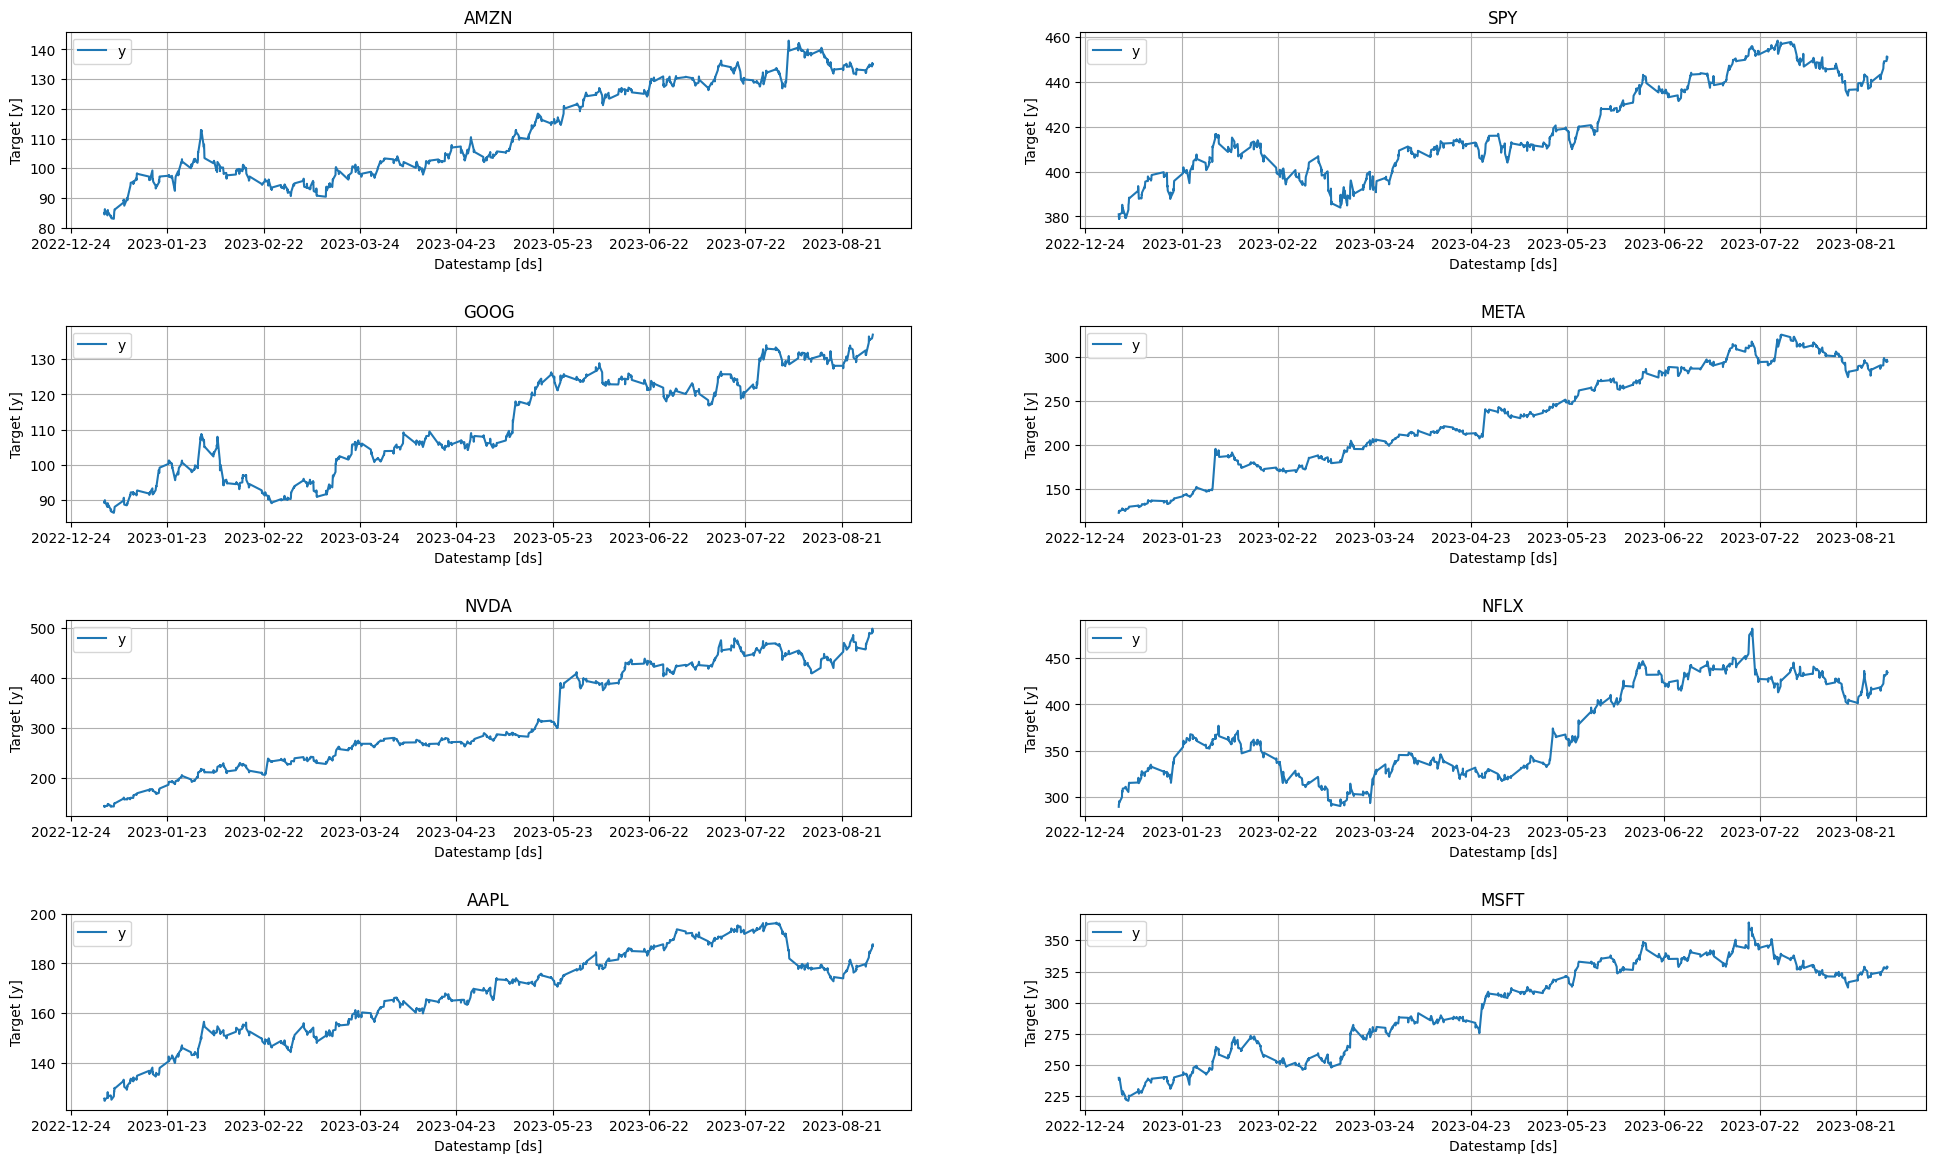

In [9]:
StatsForecast.plot(prices)

In [10]:
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1)) # calculate returns on interval 1
prices['rt'] = np.log(prices['rt']) # take log of hourly returns

returns = prices[['unique_id', 'ds', 'rt']] # limit columns
returns = returns.rename(columns={'rt': 'y'}) # rename columns
returns

,unique_id,ds,y
0,SPY,2023-01-03 09:30:00,NaN
1,SPY,2023-01-03 10:30:00,-0.002392
2,SPY,2023-01-03 11:30:00,-0.002872
3,SPY,2023-01-03 12:30:00,0.001529
4,SPY,2023-01-03 13:30:00,-0.001397
...,...,...,...
11575,NFLX,2023-08-30 11:30:00,0.000695
11576,NFLX,2023-08-30 12:30:00,-0.001882
11577,NFLX,2023-08-30 13:30:00,-0.004790
11578,NFLX,2023-08-30 14:30:00,0.004537


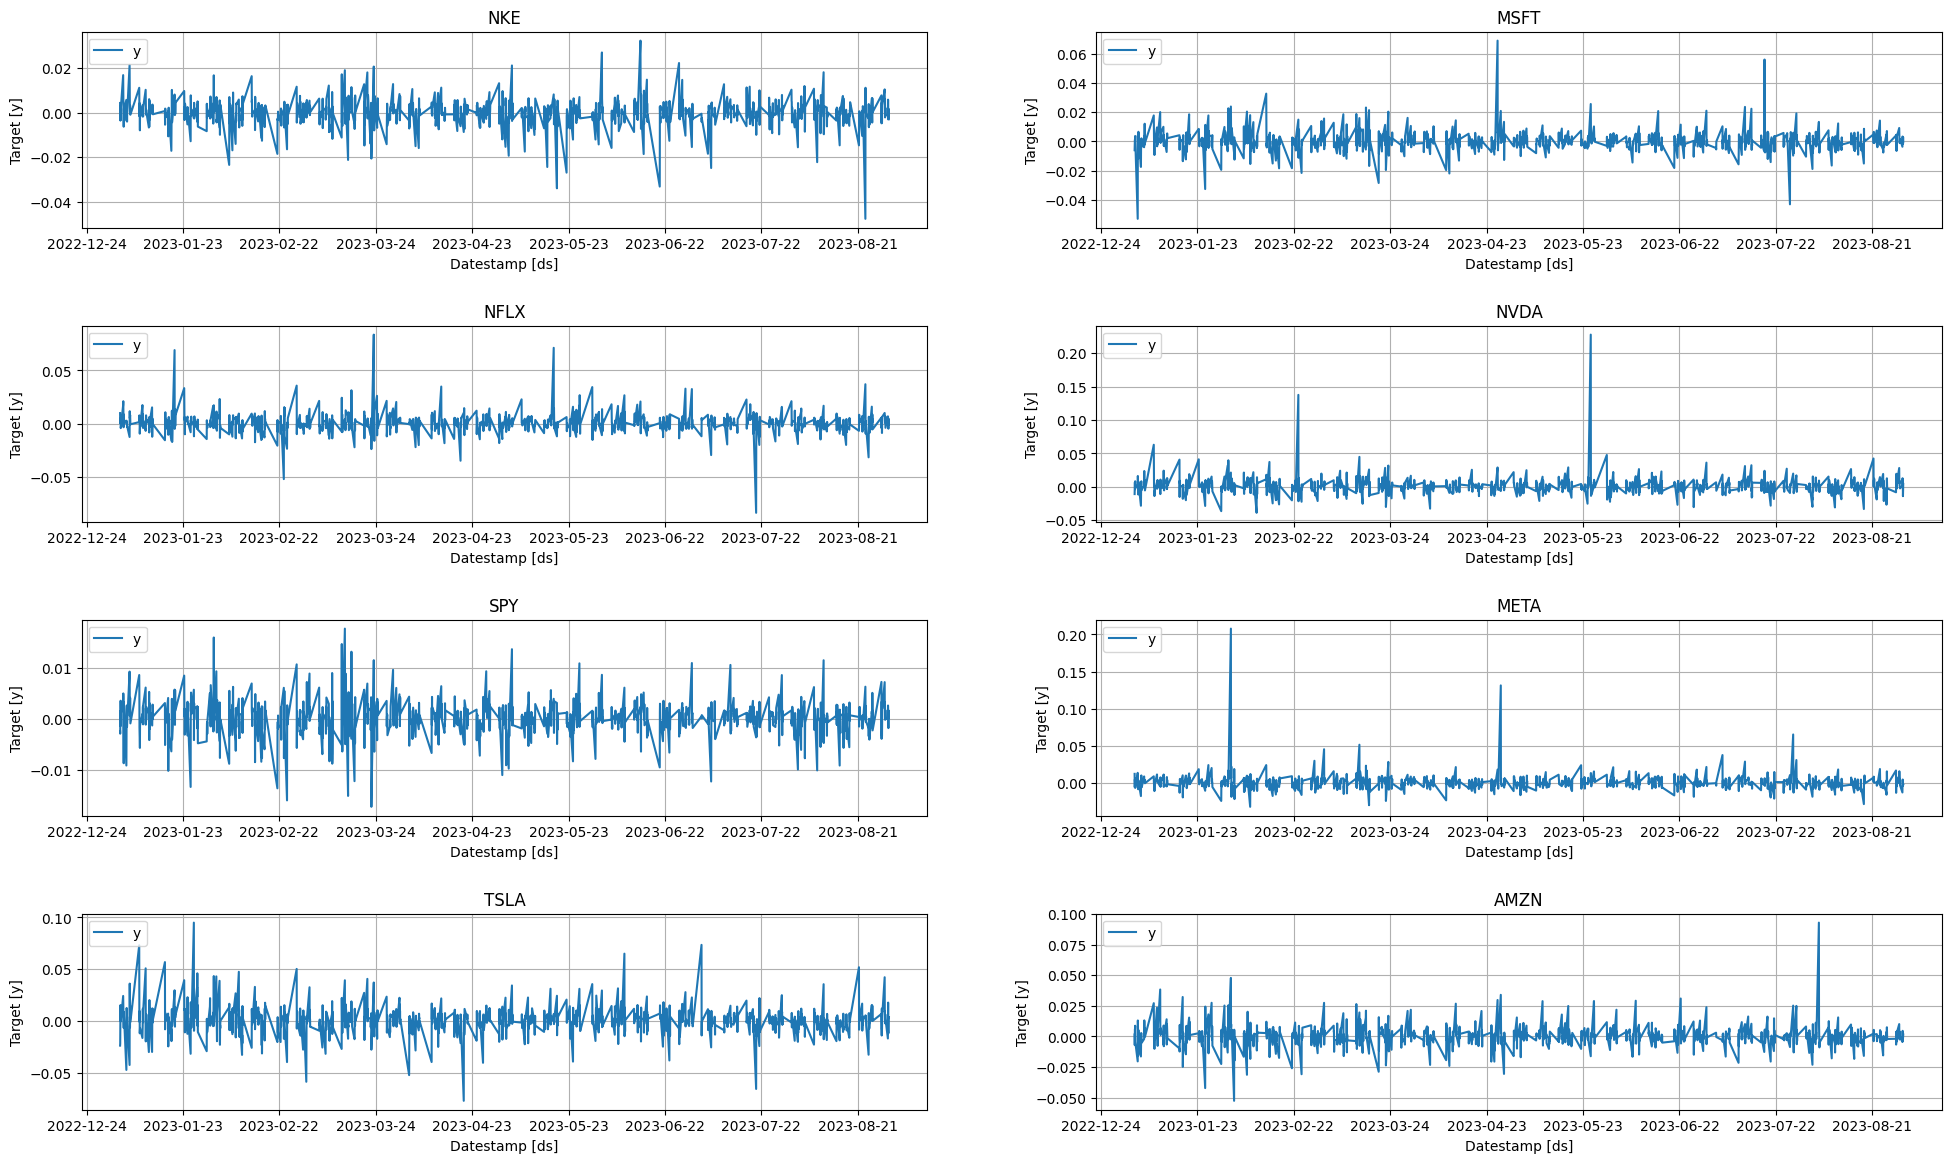

In [11]:
StatsForecast.plot(returns)

In [12]:
from statsforecast.models import (
    GARCH, 
    ARCH, 
    Naive
)

In [13]:
models = [ARCH(1), 
          ARCH(2), 
          GARCH(1,1),
          GARCH(1,2),
          GARCH(2,2),
          GARCH(2,1),
          Naive()
]

In [14]:
sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = get_hourly_market_freq(),
    n_jobs = -1 # -1 selects all available cores
)

In [15]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 7, # forecast horizon
    step_size = 7, # step size between forecasts
    n_windows = 10 # number of windows to use
)

In [16]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

,unique_id,ds,cutoff,actual,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
0,AAPL,2023-08-16 11:30:00,2023-08-16 10:30:00,-0.010354,0.008540,0.008543,0.009683,0.008294,0.035388,0.033692,-0.003175
1,AAPL,2023-08-16 12:30:00,2023-08-16 10:30:00,-0.002693,-0.003216,-0.003217,-0.003647,-0.003350,-0.013328,-0.012689,-0.003175
2,AAPL,2023-08-16 13:30:00,2023-08-16 10:30:00,0.003902,-0.002777,-0.002778,-0.003148,-0.002730,-0.011507,-0.010955,-0.003175
3,AAPL,2023-08-16 14:30:00,2023-08-16 10:30:00,-0.002240,-0.005641,-0.005643,-0.006396,-0.005650,-0.023376,-0.022255,-0.003175
4,AAPL,2023-08-16 15:30:00,2023-08-16 10:30:00,-0.001777,0.004550,0.004551,0.005159,0.004572,0.018854,0.017950,-0.003175


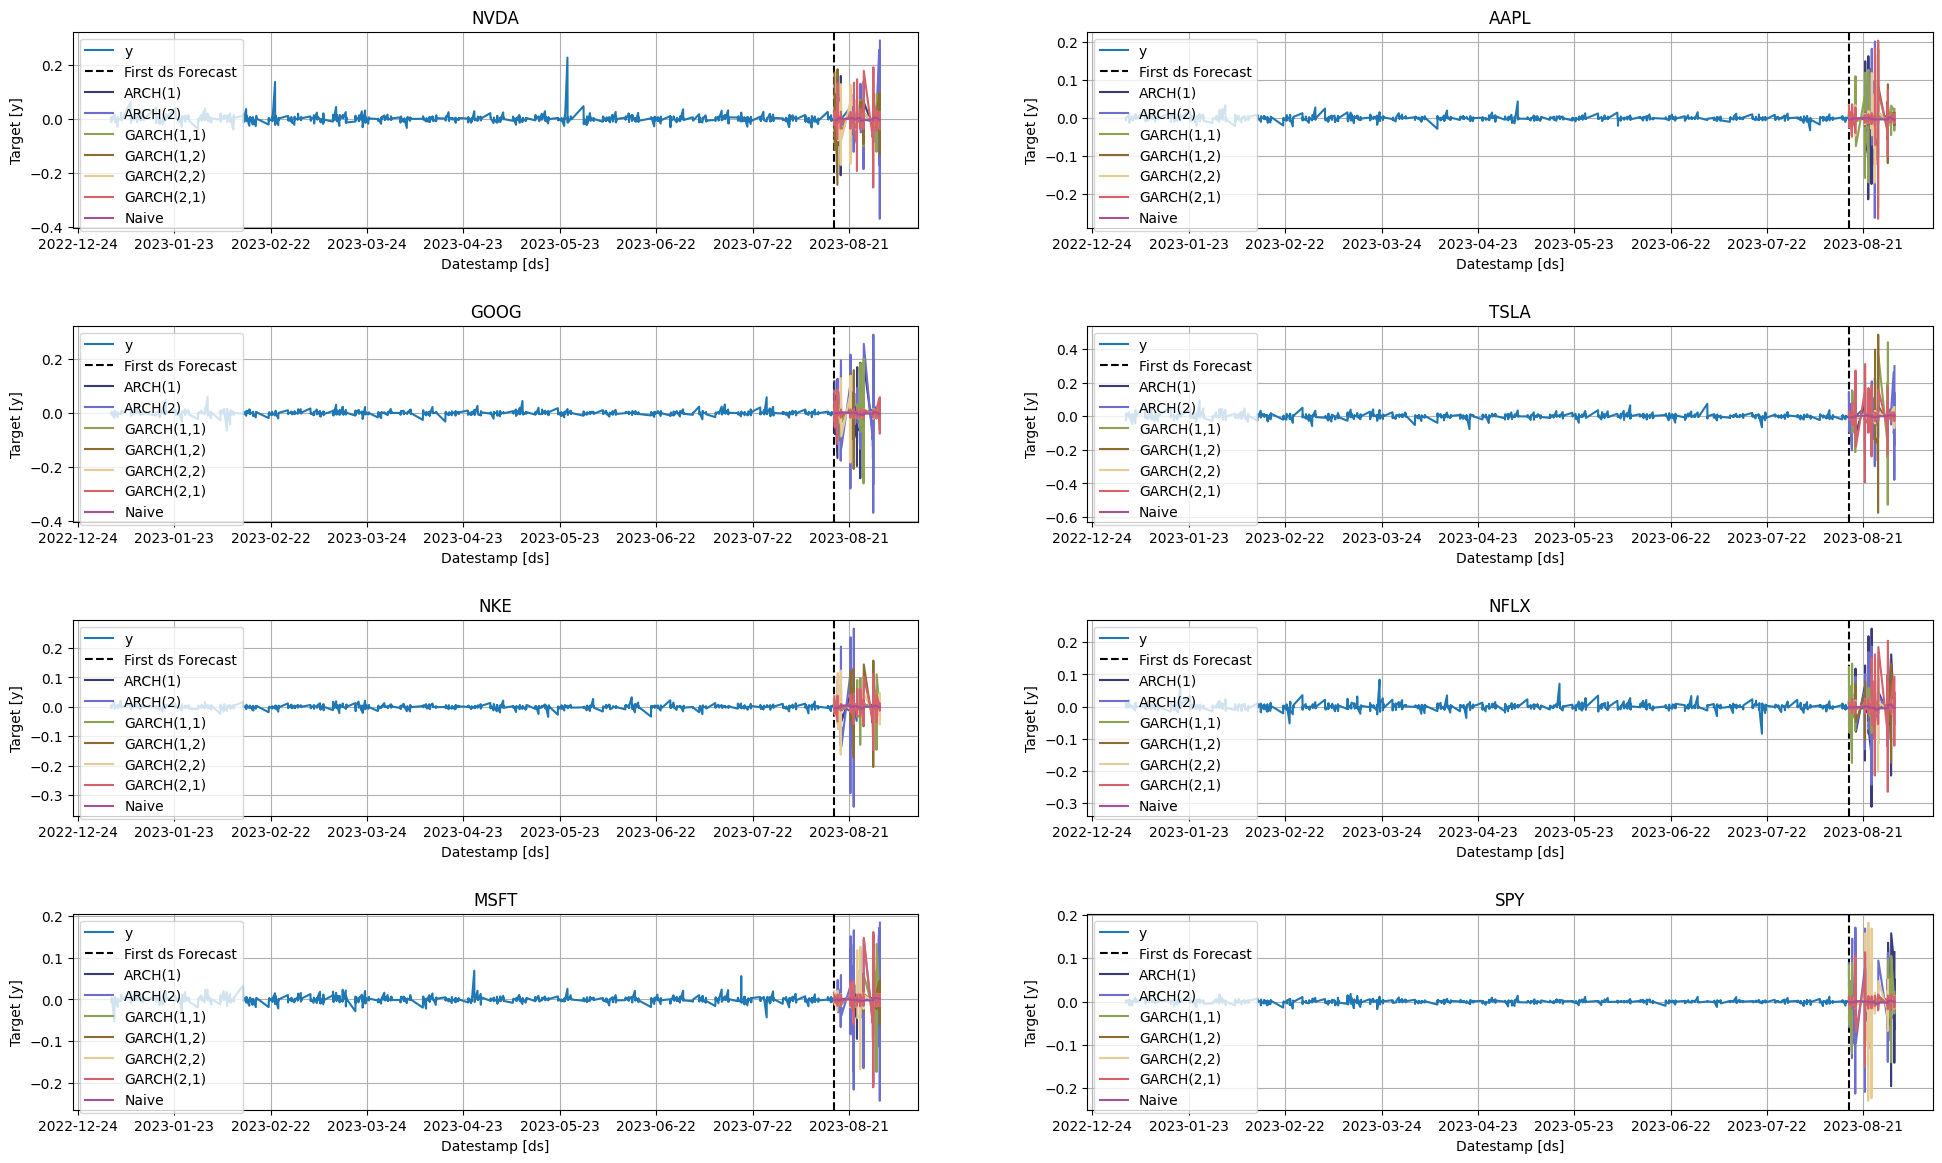

In [17]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [18]:
from datasetsforecast.losses import mae as mae_loss

In [19]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: # loop through models
        res[mod] = mae_loss(crossvalidation_df['actual'], crossvalidation_df[str(mod)]) # compute MAE
    return pd.Series(res) # return as Series

In [20]:
mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae.style.highlight_min(color = 'lightblue', axis = 1)

,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
unique_id,,,,,,,
AAPL,0.028253,0.032480,0.039539,0.015186,0.025626,0.029706,0.003639
AMZN,0.054557,0.013443,0.025684,0.026369,0.079626,0.043003,0.003918
GOOG,0.059495,0.074087,0.032301,0.021205,0.020846,0.018538,0.005028
META,0.040044,0.038322,0.047324,0.038761,0.019003,0.049324,0.005980
MSFT,0.025926,0.057009,0.021208,0.012979,0.020376,0.021952,0.003503
NFLX,0.055973,0.034590,0.027763,0.026833,0.023892,0.044522,0.006572
NKE,0.023917,0.048696,0.031512,0.033465,0.026062,0.027683,0.004793
NVDA,0.029907,0.059019,0.033943,0.042161,0.032347,0.043563,0.007696
SPY,0.028670,0.043030,0.020636,0.009025,0.034892,0.016090,0.002235


In [28]:
levels = [80, 95] # confidence levels for the prediction intervals 

forecasts = sf.forecast(h=7, level=levels)
forecasts = forecasts.reset_index()
forecasts.head(10)

,unique_id,ds,ARCH(1),ARCH(1)-lo-95,ARCH(1)-lo-80,ARCH(1)-hi-80,ARCH(1)-hi-95,ARCH(2),ARCH(2)-lo-95,ARCH(2)-lo-80,...,"GARCH(2,1)","GARCH(2,1)-lo-95","GARCH(2,1)-lo-80","GARCH(2,1)-hi-80","GARCH(2,1)-hi-95",Naive,Naive-lo-80,Naive-lo-95,Naive-hi-80,Naive-hi-95
0,AAPL,2023-08-31 10:00:00,0.014709,0.014548,0.014604,0.014814,0.014870,0.012912,0.012788,0.012831,...,0.014782,0.014620,0.014676,0.014888,0.014944,0.00152,-0.007724,-0.012617,0.010763,0.015657
1,AAPL,2023-08-31 11:00:00,-0.005540,-0.005700,-0.005645,-0.005435,-0.005379,-0.004863,-0.004987,-0.004944,...,-0.005567,-0.005729,-0.005673,-0.005461,-0.005405,0.00152,-0.011553,-0.018473,0.014592,0.021512
2,AAPL,2023-08-31 12:00:00,-0.004783,-0.004944,-0.004888,-0.004678,-0.004622,-0.004199,-0.004322,-0.004279,...,-0.004807,-0.004969,-0.004913,-0.004700,-0.004644,0.00152,-0.014491,-0.022966,0.017530,0.026005
3,AAPL,2023-08-31 13:00:00,-0.009716,-0.009877,-0.009821,-0.009611,-0.009555,-0.008529,-0.008653,-0.008610,...,-0.009764,-0.009927,-0.009870,-0.009658,-0.009602,0.00152,-0.016967,-0.026754,0.020007,0.029793
4,AAPL,2023-08-31 14:00:00,0.007837,0.007676,0.007732,0.007942,0.007997,0.006879,0.006755,0.006798,...,0.007875,0.007713,0.007769,0.007982,0.008038,0.00152,-0.019149,-0.030091,0.022189,0.033131
5,AAPL,2023-08-31 15:00:00,-0.020841,-0.021002,-0.020947,-0.020736,-0.020681,-0.018295,-0.018419,-0.018376,...,-0.020945,-0.021107,-0.021051,-0.020839,-0.020782,0.00152,-0.021122,-0.033108,0.024162,0.036148
6,AAPL,2023-09-01 09:30:00,0.015800,0.015639,0.015695,0.015905,0.015961,0.013870,0.013746,0.013789,...,0.015878,0.015716,0.015772,0.015984,0.016041,0.00152,-0.022936,-0.035883,0.025976,0.038922
7,AMZN,2023-08-31 10:00:00,0.013612,0.013474,0.013522,0.013702,0.013750,0.013618,0.013480,0.013528,...,0.013618,0.013480,0.013528,0.013708,0.013756,0.00163,-0.013591,-0.021648,0.016851,0.024908
8,AMZN,2023-08-31 11:00:00,-0.005145,-0.005284,-0.005236,-0.005054,-0.005006,-0.005147,-0.005286,-0.005238,...,-0.005147,-0.005286,-0.005238,-0.005056,-0.005008,0.00163,-0.019895,-0.031290,0.023155,0.034550
9,AMZN,2023-08-31 12:00:00,-0.004428,-0.004566,-0.004518,-0.004338,-0.004290,-0.004430,-0.004568,-0.004520,...,-0.004430,-0.004568,-0.004520,-0.004340,-0.004292,0.00163,-0.024733,-0.038688,0.027993,0.041948


In [29]:
forecasts

,unique_id,ds,ARCH(1),ARCH(1)-lo-95,ARCH(1)-lo-80,ARCH(1)-hi-80,ARCH(1)-hi-95,ARCH(2),ARCH(2)-lo-95,ARCH(2)-lo-80,...,"GARCH(2,1)","GARCH(2,1)-lo-95","GARCH(2,1)-lo-80","GARCH(2,1)-hi-80","GARCH(2,1)-hi-95",Naive,Naive-lo-80,Naive-lo-95,Naive-hi-80,Naive-hi-95
0,AAPL,2023-08-31 10:00:00,0.014709,0.014548,0.014604,0.014814,0.014870,0.012912,0.012788,0.012831,...,0.014782,0.014620,0.014676,0.014888,0.014944,0.001520,-0.007724,-0.012617,0.010763,0.015657
1,AAPL,2023-08-31 11:00:00,-0.005540,-0.005700,-0.005645,-0.005435,-0.005379,-0.004863,-0.004987,-0.004944,...,-0.005567,-0.005729,-0.005673,-0.005461,-0.005405,0.001520,-0.011553,-0.018473,0.014592,0.021512
2,AAPL,2023-08-31 12:00:00,-0.004783,-0.004944,-0.004888,-0.004678,-0.004622,-0.004199,-0.004322,-0.004279,...,-0.004807,-0.004969,-0.004913,-0.004700,-0.004644,0.001520,-0.014491,-0.022966,0.017530,0.026005
3,AAPL,2023-08-31 13:00:00,-0.009716,-0.009877,-0.009821,-0.009611,-0.009555,-0.008529,-0.008653,-0.008610,...,-0.009764,-0.009927,-0.009870,-0.009658,-0.009602,0.001520,-0.016967,-0.026754,0.020007,0.029793
4,AAPL,2023-08-31 14:00:00,0.007837,0.007676,0.007732,0.007942,0.007997,0.006879,0.006755,0.006798,...,0.007875,0.007713,0.007769,0.007982,0.008038,0.001520,-0.019149,-0.030091,0.022189,0.033131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,TSLA,2023-08-31 12:00:00,-0.006758,-0.007079,-0.006968,-0.006548,-0.006437,-0.006750,-0.007071,-0.006960,...,-0.006755,-0.007076,-0.006965,-0.006546,-0.006435,0.003939,-0.036022,-0.057175,0.043899,0.065052
66,TSLA,2023-08-31 13:00:00,-0.013729,-0.014050,-0.013939,-0.013519,-0.013408,-0.013713,-0.014033,-0.013923,...,-0.013723,-0.014044,-0.013933,-0.013514,-0.013403,0.003939,-0.042203,-0.066630,0.050081,0.074507
67,TSLA,2023-08-31 14:00:00,0.011073,0.010752,0.010863,0.011283,0.011394,0.011061,0.010740,0.010851,...,0.011069,0.010748,0.010859,0.011278,0.011389,0.003939,-0.047650,-0.074959,0.055527,0.082836
68,TSLA,2023-08-31 15:00:00,-0.029449,-0.029770,-0.029659,-0.029239,-0.029128,-0.029415,-0.029736,-0.029625,...,-0.029437,-0.029758,-0.029647,-0.029227,-0.029116,0.003939,-0.052574,-0.082489,0.060451,0.090366


In [22]:
meta_returns = returns[returns['unique_id'] == 'META']
meta_returns = meta_returns.reset_index()
meta_forecasts = forecasts[forecasts['unique_id'] == 'META']
meta_forecasts = meta_forecasts.reset_index()

In [23]:
meta_forecasts.columns.values

array(['index', 'unique_id', 'ds', 'ARCH(1)', 'ARCH(1)-lo-95',
       'ARCH(1)-lo-80', 'ARCH(1)-hi-80', 'ARCH(1)-hi-95', 'ARCH(2)',
       'ARCH(2)-lo-95', 'ARCH(2)-lo-80', 'ARCH(2)-hi-80', 'ARCH(2)-hi-95',
       'GARCH(1,1)', 'GARCH(1,1)-lo-95', 'GARCH(1,1)-lo-80',
       'GARCH(1,1)-hi-80', 'GARCH(1,1)-hi-95', 'GARCH(1,2)',
       'GARCH(1,2)-lo-95', 'GARCH(1,2)-lo-80', 'GARCH(1,2)-hi-80',
       'GARCH(1,2)-hi-95', 'GARCH(2,2)', 'GARCH(2,2)-lo-95',
       'GARCH(2,2)-lo-80', 'GARCH(2,2)-hi-80', 'GARCH(2,2)-hi-95',
       'GARCH(2,1)', 'GARCH(2,1)-lo-95', 'GARCH(2,1)-lo-80',
       'GARCH(2,1)-hi-80', 'GARCH(2,1)-hi-95', 'Naive', 'Naive-lo-80',
       'Naive-lo-95', 'Naive-hi-80', 'Naive-hi-95'], dtype=object)

In [24]:
import matplotlib.pyplot as plt

def plot_model_predictions(df_forecast):
    """
    Plot model predictions along with confidence intervals.
    
    Parameters:
        df: DataFrame containing the data
        model_name: Name of the model to plot (e.g., 'ARCH(1)', 'GARCH(1,1)', etc.)
    """
    
    # Extract appropriate columns based on the model name
    for model_name in ['ARCH(1)', 'ARCH(2)', 'GARCH(1,1)', 'GARCH(1,2)', 'GARCH(2,1)', 'GARCH(2,2)', 'Naive']:
        prediction_col = model_name
        lo_95_col = f"{model_name}-lo-95"
        lo_80_col = f"{model_name}-lo-80"
        hi_80_col = f"{model_name}-hi-80"
        hi_95_col = f"{model_name}-hi-95"
        
        # Plot model predictions
        plt.plot(df_forecast['ds'], df_forecast[prediction_col], label=f"{model_name} Prediction")
        
        # Plot confidence intervals
        # plt.fill_between(df_forecast['ds'], df_forecast[lo_80_col], df_forecast[hi_80_col], color='grey', alpha=0.5, label="80% CI")
        # plt.fill_between(df_forecast['ds'], df_forecast[lo_95_col], df_forecast[hi_95_col], color='grey', alpha=0.2, label="95% CI")
        
        # Add labels and legend
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f"{model_name} Predictions with Confidence Intervals")
    plt.legend()
    plt.show()

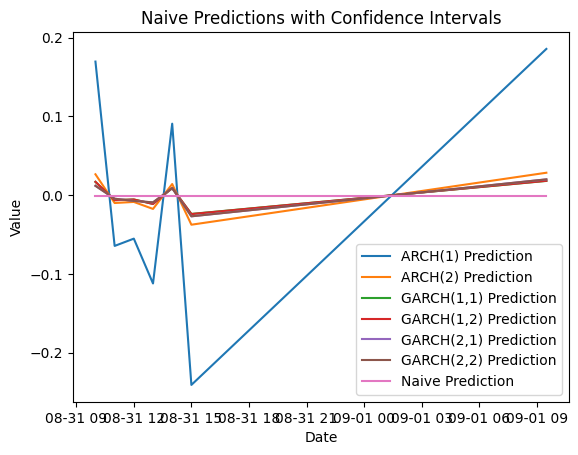

In [25]:
plot_model_predictions(meta_forecasts)

In [26]:
StatsForecast.plot(meta_returns.tail(20), meta_forecasts, level=levels, models = ['Naive'])

/Users/beneverman/Documents/Coding/bp-quant/forecasting-experiments-v1/venv/lib/python3.10/site-packages/statsforecast/core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


ZeroDivisionError: float division by zero

<Figure size 2400x350 with 1 Axes>